Goal for this notebook is to establish method for identifying years when topics spike.

Because of discrepancies in corpus coverage, I am not including content in the YI for the identification of years when end-times topics spike.

As an indication of a spike, I am using when the topic prevalence is in the top 95% of topic prevalence above that topics average prevalence in the corpus. 

As the indication of a dip, I am using when the topic prevalence is in the bottom 5% of topic prevalence below that topics average prevalence in the corpus.

The results are being saved to a file for use in other notebooks.

In [1]:
# %load ../utils/standard_library_import.py
%load_ext autoreload
%autoreload 2

import GoH.verify_model
import gspread
import json
from matplotlib import pyplot as plt
from oauth2client.service_account import ServiceAccountCredentials
import os
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# %load ../utils/import_and_preprocess_supporting_model_data.py
dataDir = "../../data/"

# Load data from Google Doc
scope = ['https://spreadsheets.google.com/feeds']
secrets = "/Users/jeriwieringa/Dissertation/dev/drafts/code/secrets/dissertation-881847769b13.json"
credentials = ServiceAccountCredentials.from_json_keyfile_name(secrets, scope)
gc = gspread.authorize(credentials)
dts = gc.open('Topic Labels').sheet1

labels = pd.DataFrame(dts.get_all_records())

with open(os.path.join(dataDir, 'params_target_300_10.18497.json')) as f:
    params = json.load(f)

metadata = pd.read_csv(os.path.join(dataDir, 'meta.csv'), header=None).reset_index()
metadata.columns = ['doc_id', 'filename', 'citation', 'author', 
                    'periodical_name', 'volume', 'issue', 
                    'date', 'page', 'url','abrev']
metadata['date_formatted'] = pd.to_datetime(metadata['date'])

In [17]:
import GoH.analyze_model

In [3]:
model = pd.read_csv(os.path.join(dataDir, 'dt_target_300_10.18497.csv'))

In [4]:
model[:10]

,doc_id,topic,word_counts
0,0,11,10
1,0,14,7
2,0,94,14
3,0,102,2
4,0,113,23
5,0,136,12
6,0,144,1
7,0,165,1
8,0,171,12
9,0,175,1


In [14]:
titles = metadata['abrev'].unique().tolist()
titles.remove('YI')

In [15]:
titles

['ADV',
 'AmSn',
 'ARAI',
 'CE',
 'CUV',
 'EDU',
 'GCB',
 'GH',
 'GOH',
 'GS',
 'HM',
 'HR',
 'IR',
 'LB',
 'LH',
 'LibM',
 'LUH',
 'NMN',
 'PHJ',
 'PTAR',
 'PUR',
 'RH',
 'Sligo',
 'SOL',
 'ST',
 'SUW',
 'TCOG',
 'TMM',
 'WMH']

In [19]:
yearly_data = GoH.analyze_model.prepare_data_set(model, metadata, 
                                             smooth_value=params['alpha_sum'], smooth=True,
                                             subset=True, doc_set=titles,  
                                             norm=True, verify=True)

1.0


In [22]:
yearly_data[:5]

,topic,year,topic_proportion
0,0,1849,0.003254
1,0,1850,0.003167
2,0,1851,0.002510
3,0,1852,0.002377
4,0,1853,0.002435


In [23]:
yearly_data.shape[1]

3

In [25]:
ymatrix = yearly_data.pivot(index="year", columns="topic", values = "topic_proportion")

For each topic (feature), identify years when that topic's prevalence is in the top and bottom quantiles. 
Get results that look like {topic_id: {high: {year: weight,}, low: {year: weight,}}}

In [32]:
def identify_single_years_range(df, quantile):
    dictionary = {}
    
    for i in range(0, df.shape[1]):
        series = df[i]
        years = series[series.between(*series.quantile(quantile))].to_dict()
        
        dictionary[i] = years
    
    return pd.DataFrame.from_dict(dictionary, orient='columns')


def label_changes(row, label = 'Spike'):
    
    if pd.isnull(row['weight']) == True:
        pass
    else:
        return label

    
def encode_changes(row, label = 1):
    
    if pd.isnull(row['weight']) == True:
        pass
    else:
        return label
    
    
def identify_spikes_and_dips(df, percentile):
    highPrevalence = identify_single_years_range(df, [1-percentile, 1]).unstack().reset_index()
    highPrevalence.columns = ['topic_id', 'year', 'weight']
    highPrevalence['label'] = highPrevalence.apply (lambda row: label_changes (row),axis=1)
    highPrevalence['encoding'] = highPrevalence.apply(lambda row: encode_changes(row), axis=1)
    
    lowPrevalence = identify_single_years_range(df, [0,0+percentile]).unstack().reset_index()
    lowPrevalence.columns = ['topic_id', 'year', 'weight']
    lowPrevalence['label'] = lowPrevalence.apply(lambda row: label_changes(row, label='Dip'), axis =1)
    lowPrevalence['encoding'] = lowPrevalence.apply(lambda row: encode_changes(row, label=-1), axis = 1)
    
    
    return highPrevalence.append(lowPrevalence)

In [26]:
highPrevalence = identify_single_years_range(ymatrix, [0.95, 1])
highPrevalence[:10]

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
1849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012597,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855,NaN,NaN,NaN,NaN,0.009438,NaN,NaN,NaN,NaN,NaN,...,0.005676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,0.009105,NaN,0.004995,NaN,NaN,NaN,...,0.007709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,NaN,NaN,NaN,NaN,0.009397,NaN,NaN,0.010255,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
import seaborn as sns

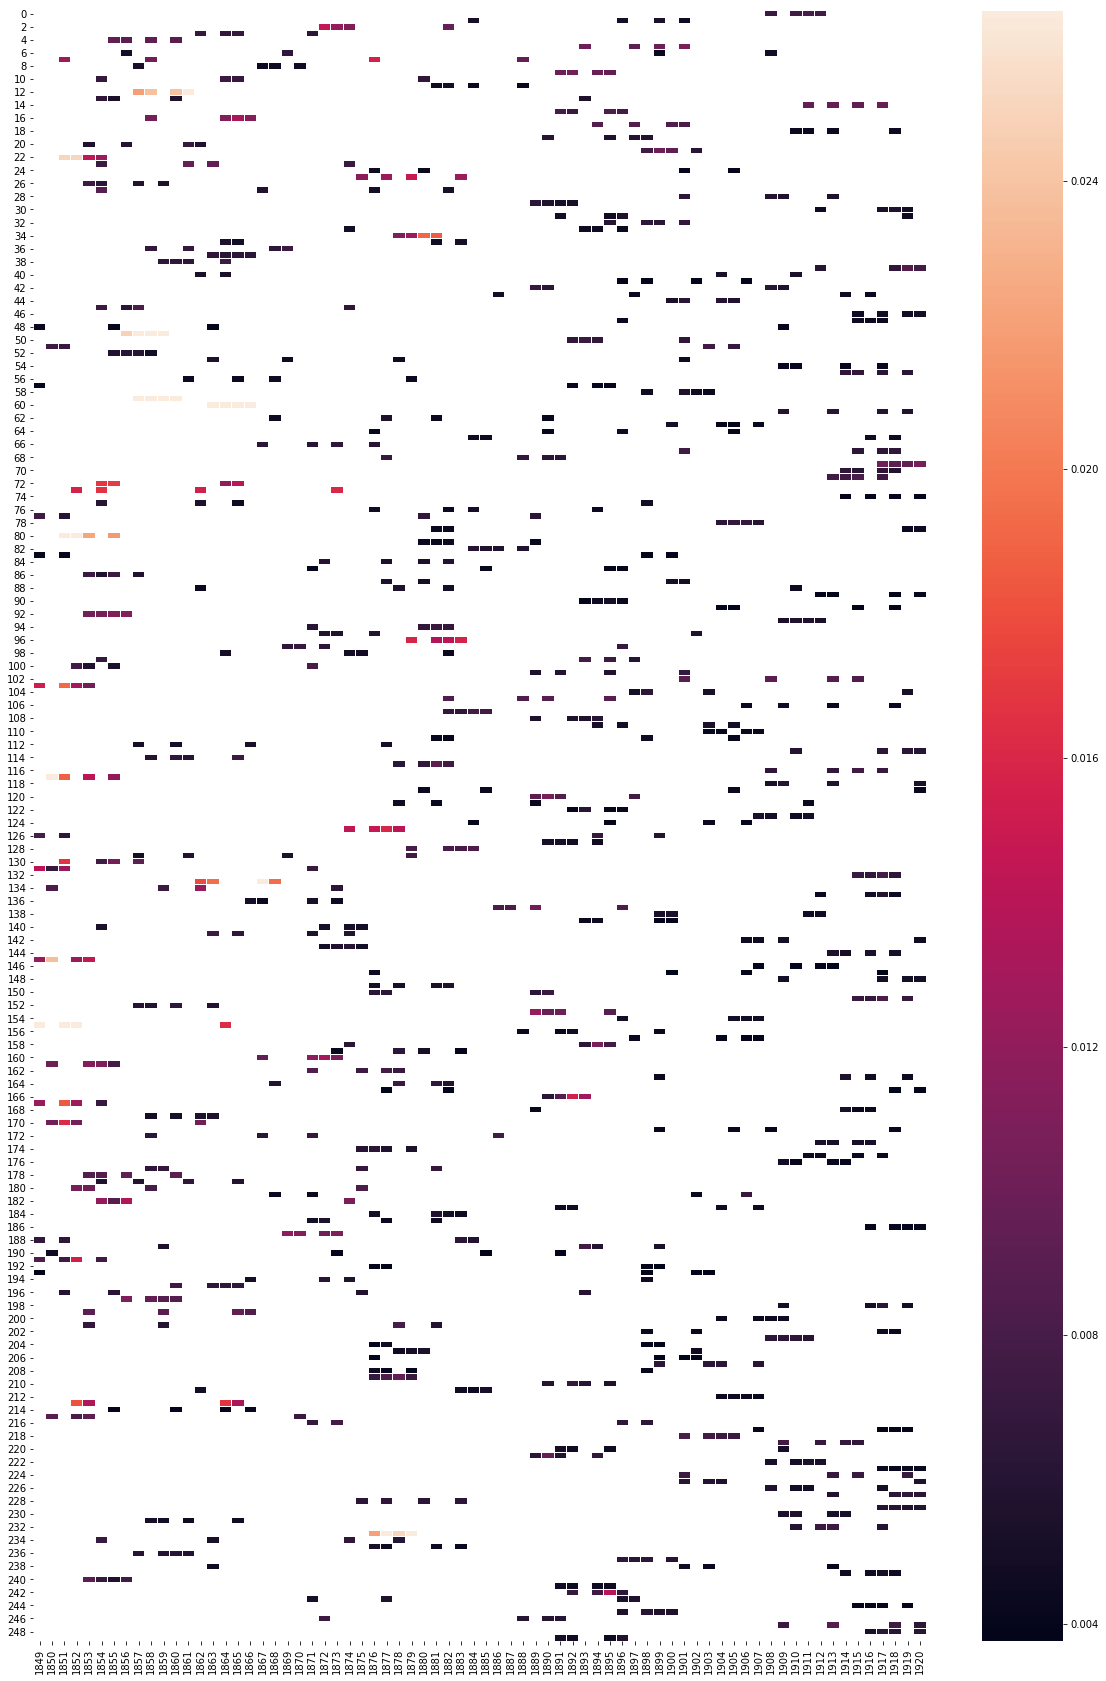

In [28]:
plt.subplots(figsize=(20,30))
sns.heatmap(highPrevalence.transpose(), linewidths=.1, robust=True)

In [29]:
lowPrevalence = identify_single_years_range(ymatrix, [0, 0.05])
lowPrevalence[:10]

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
1849,NaN,NaN,NaN,NaN,NaN,0.004122,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003220,NaN,NaN,NaN,NaN,NaN,NaN
1851,NaN,NaN,NaN,0.002609,NaN,0.004750,NaN,NaN,0.002962,NaN,...,NaN,NaN,NaN,0.002993,NaN,NaN,0.002479,NaN,NaN,NaN
1852,0.002377,0.002321,NaN,0.002948,NaN,0.004580,NaN,NaN,0.003207,NaN,...,0.00298,0.002377,0.002333,NaN,NaN,0.002316,0.002324,0.002374,0.002327,0.002436
1853,0.002435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.002460,0.003087,NaN,NaN,0.002423,NaN,NaN,NaN
1854,NaN,0.002335,NaN,NaN,NaN,0.005117,NaN,NaN,0.002774,0.002427,...,NaN,NaN,0.002445,0.003096,0.002327,0.002364,0.002413,0.002337,0.002336,0.002351
1855,0.002418,0.002303,NaN,NaN,NaN,NaN,0.002806,NaN,NaN,0.002395,...,NaN,NaN,0.002407,NaN,NaN,0.002313,NaN,NaN,0.002334,0.002414
1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.002399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002411
1857,0.002417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.002439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


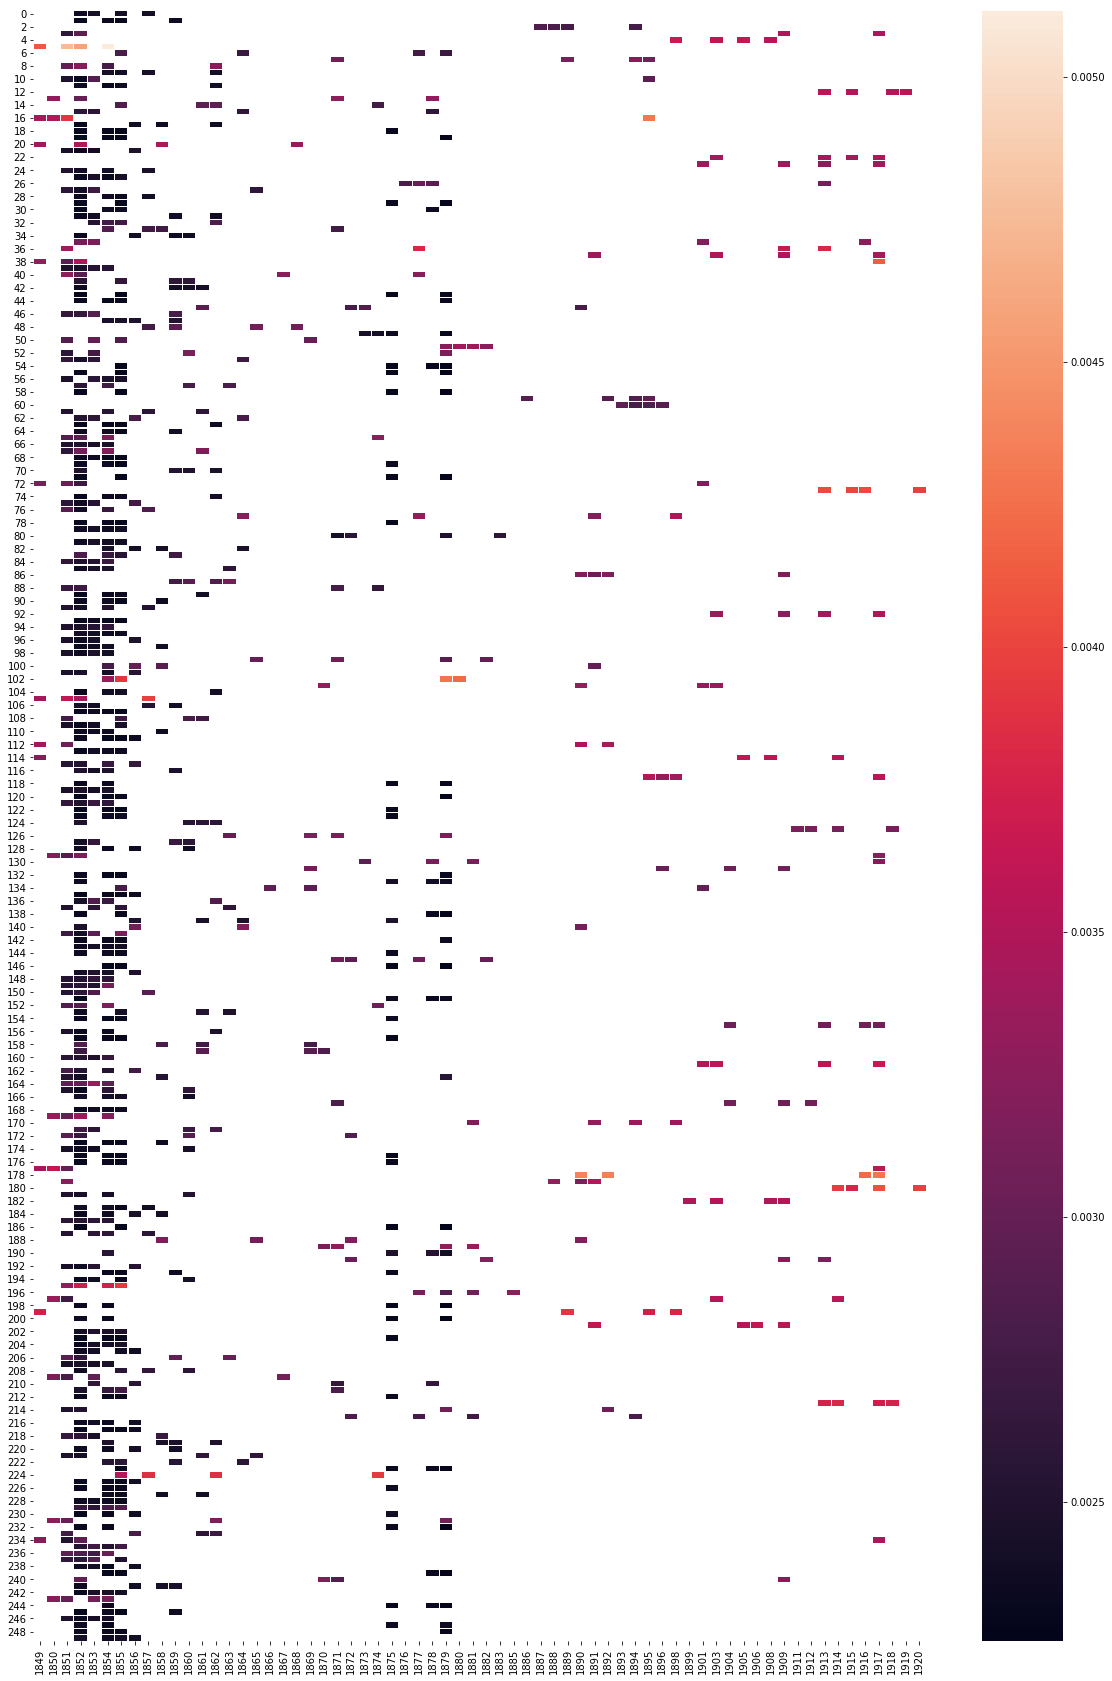

In [30]:
plt.subplots(figsize=(20,30))
sns.heatmap(lowPrevalence.transpose(), linewidths=.1)

In [31]:
def label_changes(row, label = 'Spike'):
    
    if pd.isnull(row['weight']) == True:
        return 'Average'
    else:
        return label
    
def encode_changes(row, label = 1):
    
    if pd.isnull(row['weight']) == True:
        return 0
    else:
        return label

In [33]:
combined = identify_spikes_and_dips(ymatrix, 0.05).dropna()

In [34]:
combined[:10]

,topic_id,year,weight,label,encoding
59,0,1908,0.007282,Spike,1.0
61,0,1910,0.007714,Spike,1.0
62,0,1911,0.008117,Spike,1.0
63,0,1912,0.007791,Spike,1.0
107,1,1884,0.005194,Spike,1.0
119,1,1896,0.004983,Spike,1.0
122,1,1899,0.005351,Spike,1.0
124,1,1901,0.004729,Spike,1.0
167,2,1872,0.014629,Spike,1.0
168,2,1873,0.012166,Spike,1.0


In [35]:
matrix = combined.pivot(index='year', columns="topic_id", values='encoding').fillna(0)

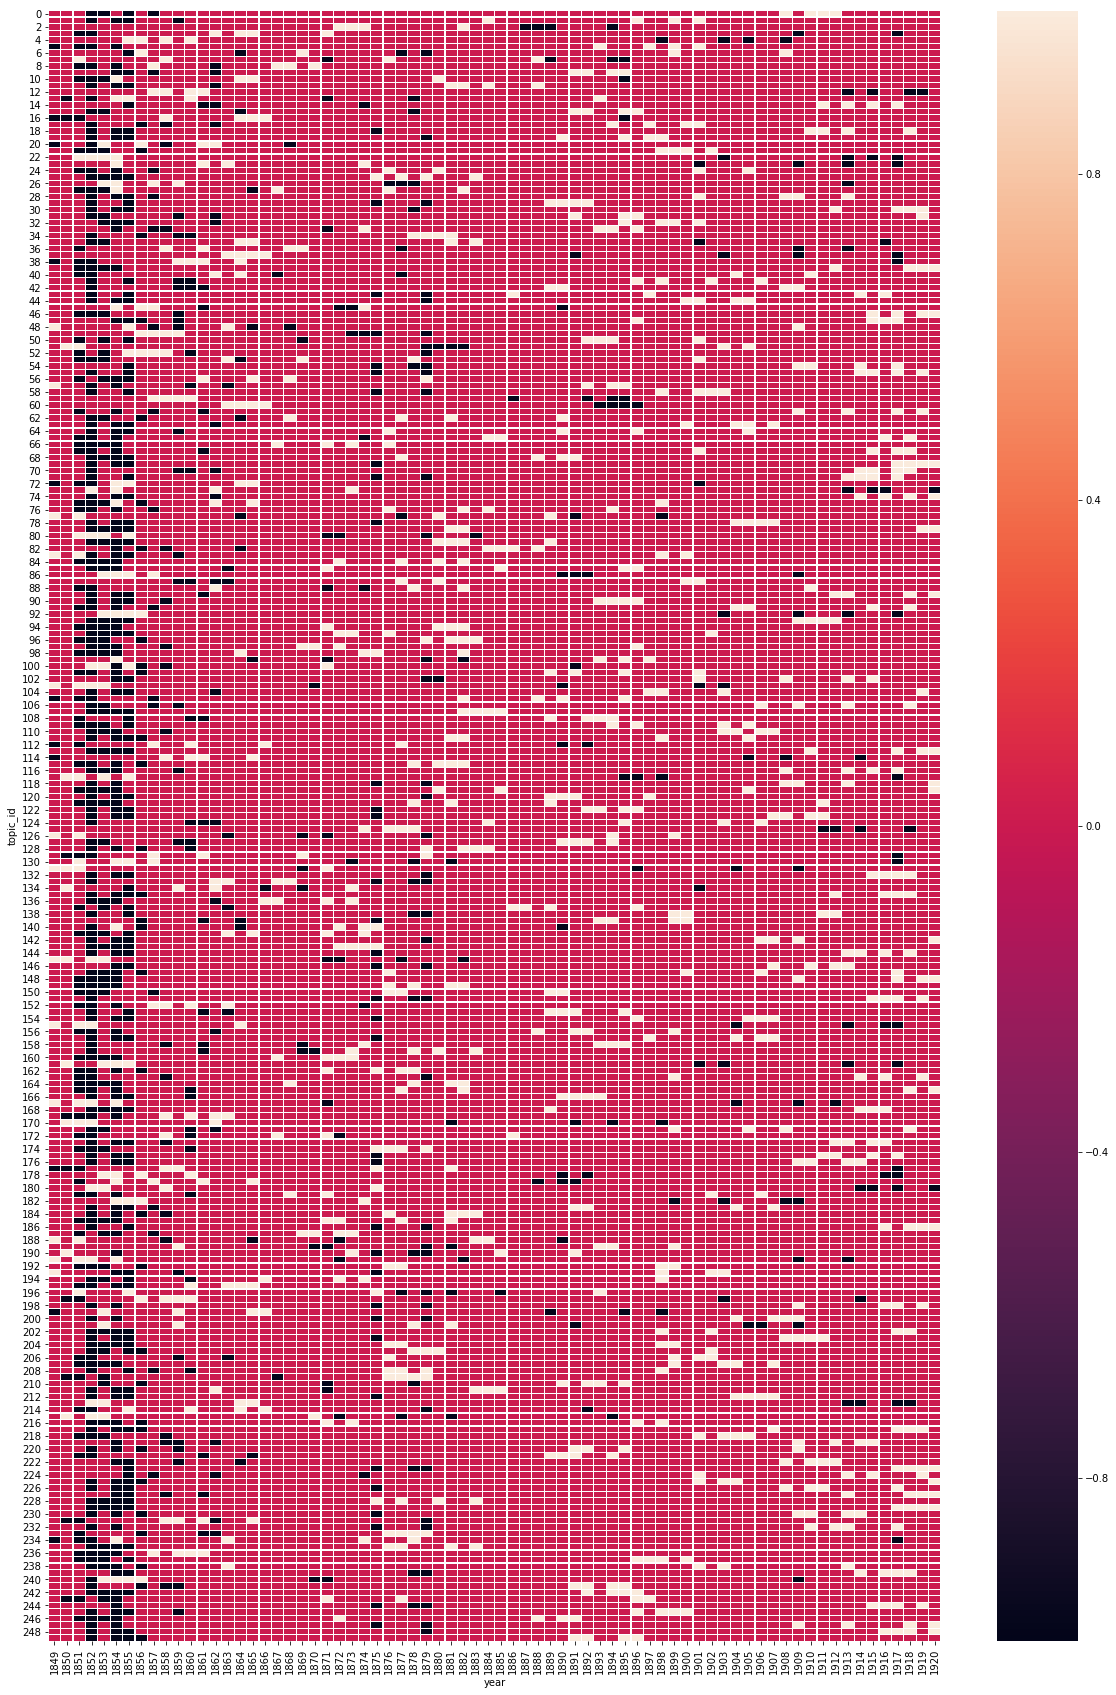

In [36]:
plt.subplots(figsize=(20,30))
sns.heatmap(matrix.transpose(), linewidths=.1, robust=True)
plt.savefig(os.path.join(dataDir, 'spikes_and_dips.png'))

In [37]:
combined.to_csv(os.path.join(dataDir, 'list_of_topic_spikes_and_dips.csv'))

## Cycles in denominational titles

In [38]:
denominational_titles = ['RH', 'ST', 'ARAI', 'GCB', 'PTAR','TCOG']

In [39]:
denom_data = GoH.analyze_model.prepare_data_set(model, metadata, 
                                             smooth_value=params['alpha_sum'], smooth=True,
                                             subset=True, doc_set=denominational_titles,  
                                             norm=True, verify=True)

1.0


In [40]:
denom_matrix = denom_data.pivot(index="year", columns="topic", values = "topic_proportion")

In [41]:
denom = identify_spikes_and_dips(denom_matrix, 0.05).dropna()

In [42]:
denom_matrix = denom.pivot(index='year', columns="topic_id", values='encoding').fillna(0)

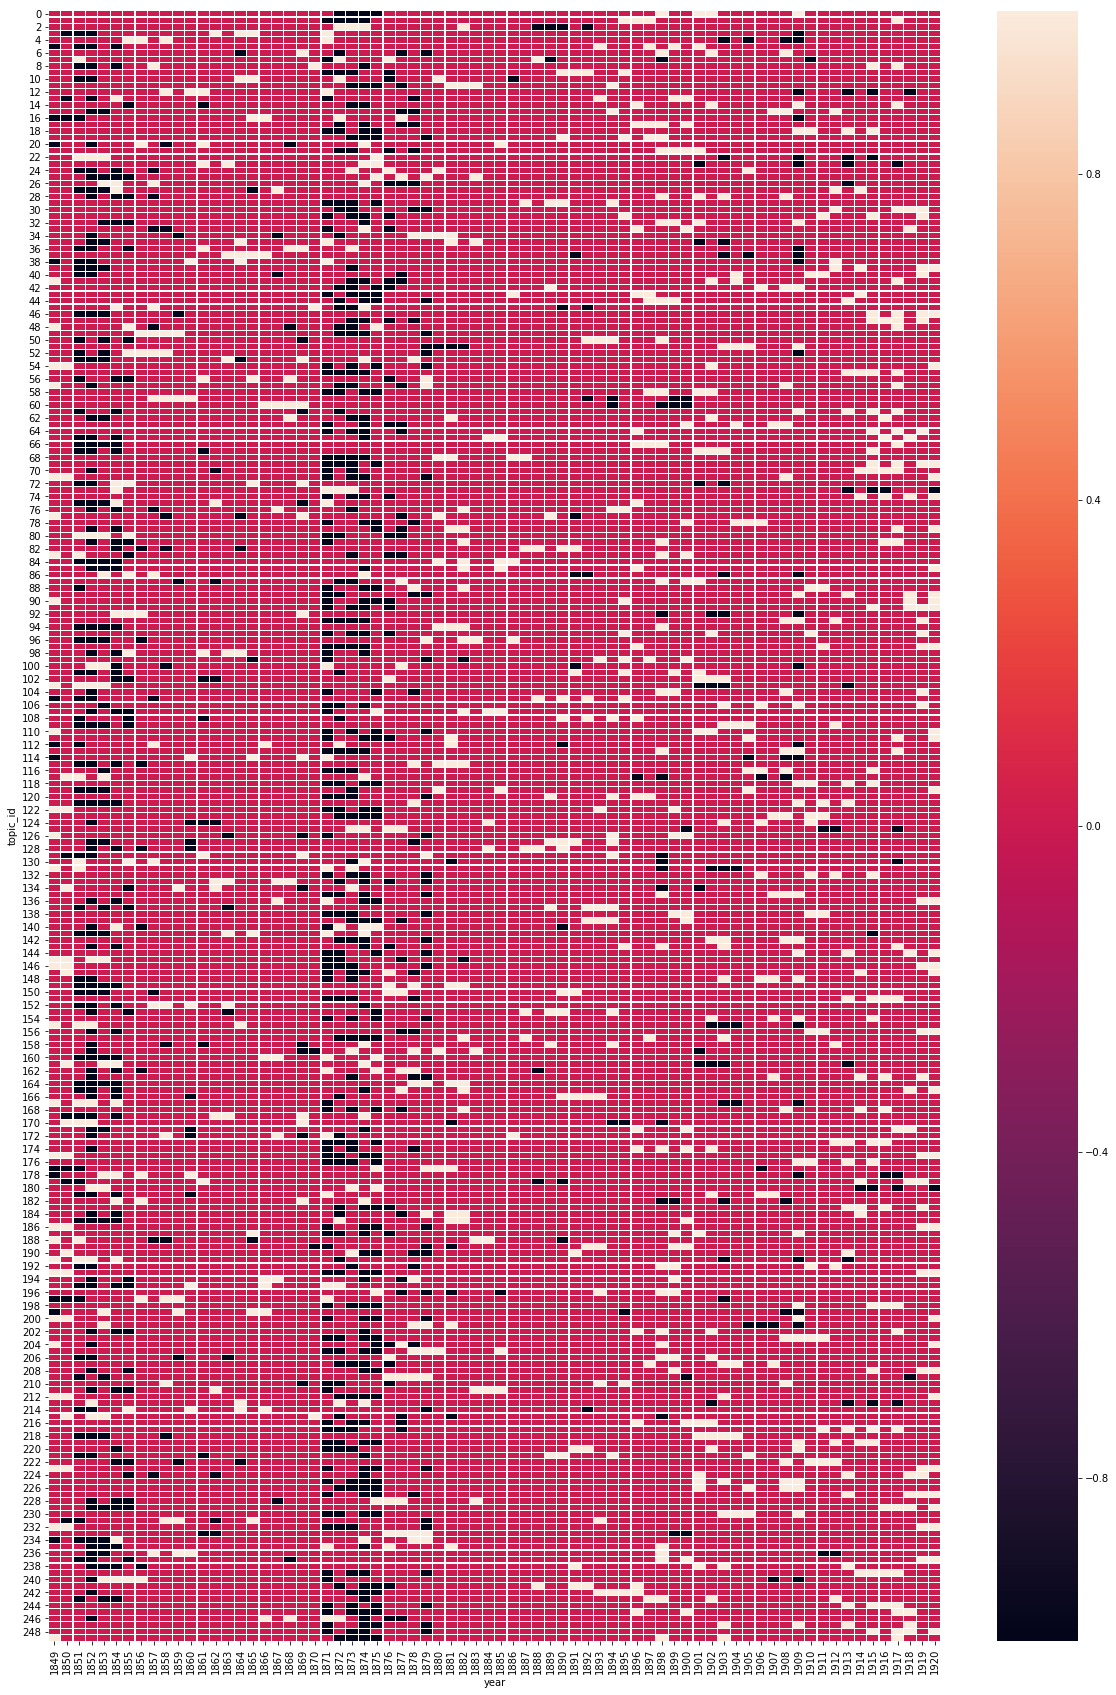

In [43]:
plt.subplots(figsize=(20,30))
sns.heatmap(denom_matrix.transpose(), linewidths=.1, robust=True)

In [44]:
denom.to_csv(os.path.join(dataDir, 'list_of_topic_spikes_and_dips_denominational_titles.csv'))